# COVID-19 Lung Leision Segmentation

In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
sys.path.append(project_dir)
sys.path.append(data_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [4]:
class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None, transforms=None):

        self.pairs_dir = os.path.join(data_dir, folder)
        self.pairs_file = sorted(glob.glob(os.path.join(self.pairs_dir, '*.npy')))
        self.transforms = transforms
                
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.pairs_file):
            n_sample = len(self.pairs_file)
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])

            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]        
        file_name = glob.glob(os.path.join(self.pairs_dir, '*_pairs_{0:04d}.npy'.format(idx)))
        assert len(file_name) == 1
        img, mask = np.load(file_name[0])
        # print(file_name[0])
        # show_pair(img, mask, idx)
        img = np.array(img * 255, dtype = np.uint8)
        
        if self.transforms:
            img = self.transforms(image=img, mask=mask)

        # Resize all images from 512 to 256 (H and W)
        img_size = 256
        img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
        mask = cv2.resize(mask, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')

        # Scale img between 0 to 1
        img = np.array(img) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1

        # Add an axis to the image array so that it is in [channel, height, width] format.
        img = np.expand_dims(img, axis=0)
                    
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.LongTensor),
            'img_id': idx
        }

<b> Load Datasets </b>

In [5]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('PairedTrainData')
valid_dataset = BasicDataset('PairedValidData')
test_dataset = BasicDataset('PairedTestData')

# train_dataset = BasicDataset('Train')
# valid_dataset = BasicDataset('Validation')

<b> Check Data Shape </b>

x shape is torch.Size([1, 256, 256])
y shape is torch.Size([256, 256])


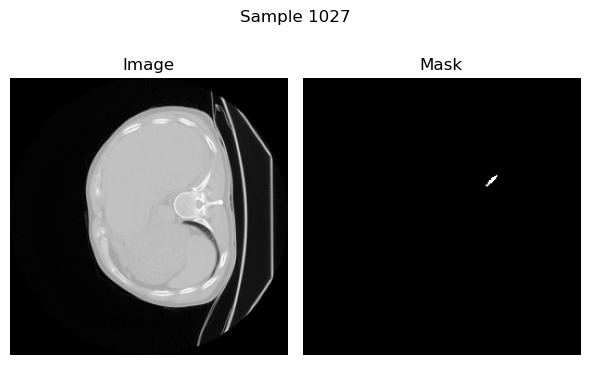

In [6]:
sample = np.random.randint(0, len(train_dataset))
sample_data = train_dataset.__getitem__(sample)
x = sample_data['image']
y = sample_data['mask']
idx = sample_data['img_id']
img, mask = x, y

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')


def show_pair(img, mask, idx):
    plt.figure(dpi=100)
    plt.suptitle(f'Sample {idx:04d}')

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_pair(x[0], y, idx)

In [7]:
pd.DataFrame(img.flatten()).describe(), pd.DataFrame(mask.flatten()).describe()

(                  0
 count  65536.000000
 mean       0.262904
 std        0.336328
 min        0.000000
 25%        0.007843
 50%        0.023529
 75%        0.721569
 max        1.000000,
                   0
 count  65536.000000
 mean       0.000549
 std        0.023431
 min        0.000000
 25%        0.000000
 50%        0.000000
 75%        0.000000
 max        1.000000)

<b> Show Data Split </b>

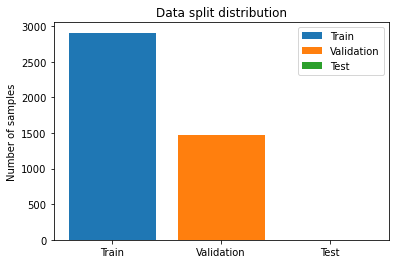

In [8]:
def show_datasets(train_dataset, valid_dataset, test_dataset):
    plt.figure()
    plt.title('Data split distribution')
    plt.bar(0, len(train_dataset), label='Train')
    plt.bar(1, len(valid_dataset), label='Validation')
    plt.bar(2, len(test_dataset), label='Test')
    plt.ylabel('Number of samples')
    plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
    plt.legend()
    plt.show()

show_datasets(train_dataset, valid_dataset, test_dataset)

### Implement U-Net model

<div align="center">
  <img width="400px" src="https://github.com/soroush361/AoE_BME/blob/main/modified_UNet_arch_2.png?raw=true" />
</div>


Now we can create an instance of our implemented model.

In [10]:
from networks import UNet, UNet_Reduced

# define model
# my_UNet = UNet('MyUNet', 1, 2) # output classes = 2
my_UNet = UNet_Reduced('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

# Printing the parameter number
all_params = [param.numel() for param in my_UNet.parameters() if param.requires_grad]
print("total model parameters:", sum(all_params))

total model parameters: 1813218


<b>Initial Weights </b>

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample batch 'image 'shape is: torch.Size([4, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([4, 256, 256])
Predicted mask shape is: torch.Size([4, 2, 256, 256])


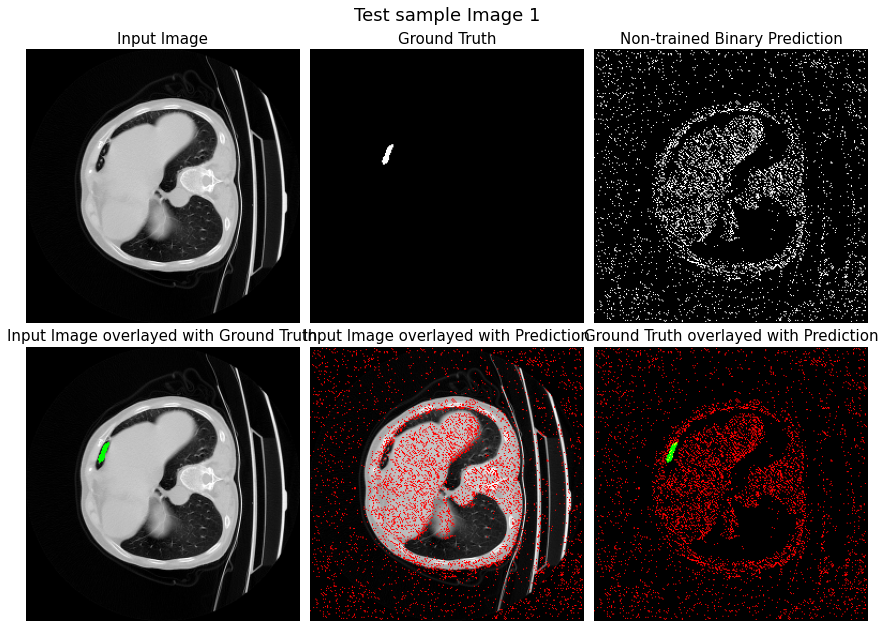

In [11]:
from utils import show_mask

# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset('PairedTrainData', n_sample=1000)
valid_dataset = BasicDataset('PairedTrainData', n_sample=200)

train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=4, pin_memory=True, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, num_workers=4, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True)

show_mask(my_UNet, valid_dataloader)

### 3. Train the model

In [15]:
from .run_network import train_net

optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, step_size=30, gamma=0.5)
# use precalculated class weight for class imbalance
# class_weights = get_class_weight(train_dataset)
class_weights = torch.tensor([1, 100], dtype=torch.float).cuda()
criteria = nn.CrossEntropyLoss(weight=class_weights)
EPOCHS = 100
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, criteria)

trigger times: 0lidation Batch 50/50 - Loss: 0.388303, DICE score: 0.183153, Jaccard score: 0.100808            
EPOCH 1/100 - Training Loss: 0.490682, Training DICE score: 0.156762, Training Jaccard score: 0.098541, Validation Loss: 0.448499, Validation DICE score: 0.138839, Validation Jaccard score: 0.077345
trigger times: 0lidation Batch 50/50 - Loss: 0.361858, DICE score: 0.241088, Jaccard score: 0.137066            
EPOCH 2/100 - Training Loss: 0.423975, Training DICE score: 0.175237, Training Jaccard score: 0.111491, Validation Loss: 0.415139, Validation DICE score: 0.218340, Validation Jaccard score: 0.132722
trigger times: 0lidation Batch 50/50 - Loss: 0.345731, DICE score: 0.303802, Jaccard score: 0.179108            
EPOCH 3/100 - Training Loss: 0.403440, Training DICE score: 0.182325, Training Jaccard score: 0.116146, Validation Loss: 0.408454, Validation DICE score: 0.240103, Validation Jaccard score: 0.148871
trigger times: 1lidation Batch 50/50 - Loss: 0.343446, DICE scor

### Display results

In [ ]:
from utils import show_training
show_training(EPOCHS, train_loss, valid_loss, train_dice, valid_dice, train_jaccard, valid_jaccard)

Then, let us see in which epoch the model obtained the highest validation DICE score and load the weights of that epoch as our best model weights.

In [ ]:
best_epoch = np.argmax(valid_dice) + 1 # epochs starts at 1
print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

Now we can check the performance of the best model on our previously pulled example.

In [ ]:
# take first batch of test set
show_mask(my_UNet, test_dataloader)

In [ ]:
from .run_network import test_net

test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, criteria)
print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2])
plt.ylabel('True labels')
plt.xlabel('predicted labels')